In [1]:
''' Feature Selection with Various Methods for Mortality Paper
'''

import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
import seaborn as sns
import sklearn
from sklearn import impute
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from collections import defaultdict

%matplotlib inline

## Necessary Functions

In [27]:
# This function scales the data by Standard Scaling and saves the result

def standard_scaler(data, file_path):
    scaler = StandardScaler()
    scaler.fit(data)
    data_scaled = pd.DataFrame(scaler.transform(data))
    data_scaled.columns = data.columns
    data_scaled.to_csv(file_path + '.csv')
    
    return data_scaled

In [28]:
# This function scales the data by MinMax Scaling and saves the result

def min_max_scaler(data, file_path):
    
    min_max_scaler = MinMaxScaler()
    data_minmax = min_max_scaler.fit_transform(data)
    data_minmax = pd.DataFrame(data_minmax, columns = data.columns)
    data_minmax.columns = data.columns
    data_minmax.to_csv(file_path + '.csv')
    
    return data_minmax

In [31]:
# This function performs Hierarchical clustering of spearman correlation coefficients and returns the distances

def hierachical_clustering_corr(data, file_path):

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 20))
    corr = spearmanr(data).correlation

    # Ensure the correlation matrix is symmetric
    corr = (corr + corr.T) / 2
    np.fill_diagonal(corr, 1)

    # We convert the correlation matrix to a distance matrix before performing
    # hierarchical clustering using Ward's linkage.
    distance_matrix = 1 - np.abs(corr)
    dist_linkage = hierarchy.ward(squareform(distance_matrix))
    dendro = hierarchy.dendrogram(
        dist_linkage, labels=data.columns.tolist(), ax=ax1, leaf_rotation=90, leaf_font_size= 10)
    dendro_idx = np.arange(0, len(dendro["ivl"]))

    ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
    ax2.set_xticks(dendro_idx)
    ax2.set_yticks(dendro_idx)
    ax2.set_xticklabels(dendro["ivl"], rotation="vertical", fontsize = 10)
    ax2.set_yticklabels(dendro["ivl"], fontsize = 10)
    fig.tight_layout()
    plt.savefig(file_path)
    
    return dist_linkage

In [30]:
# This function performs feature selection based on the distances provided by hierarchical clustering

def feature_selection(dist_linkage, thr, data):
    cluster_ids = hierarchy.fcluster(dist_linkage, thr, criterion="distance")
    cluster_id_to_feature_ids = defaultdict(list)
    for idx, cluster_id in enumerate(cluster_ids):
        cluster_id_to_feature_ids[cluster_id].append(idx)
    selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]
    print(data.columns[selected_features])
    data_selected_features = data.iloc[:,selected_features]
    
    return data_selected_features, selected_features

In [32]:
# This function makes training and test datasets out of provided data based on the NAKO participants 

def make_train_test_data(NAKO_data_path, file_path, data = None):
    
    # Read the aggregated 5km NAKO data to find cells with NAKO participants
    NAKO_data = pd.read_excel(NAKO_data_path)

    # convert the data type from object to string
    NAKO_data.id = NAKO_data.id.astype('string')

    # Merge (left-merge) SES data and NAKO to make training and test data
    data = pd.merge(data, NAKO_data, on = ['id'], how = 'left')

    # Make training data out of merged data by considering the cells where number of participants is not null
    training_data = data[data['n_particip'].isna() == False]
    
    # Drop unnecessary features
    training_data = training_data.drop(['n_particip'], axis = 1)

    # Save training data
    training_data.to_csv(file_path + '_Training_data.csv', sep=',', index=False)

    # Make test data out of SES_data by considering the cells where number of participants is null
    test_data = data[data['n_particip'].isna()]

    # Drop unnecessary features
    test_data = test_data.drop(['n_particip'], axis = 1)
    test_data.head()

    # Save test data
    test_data.to_csv(file_path + '_Test_data.csv', sep=',', index=False)

## loading the data

In [33]:
os.chdir("N:/WG_ENRI/20_projects/Noise2NAKO/04_data/grid_prediction/3_output")
NAKO_data_path = 'N:\\WG_ENRI\\20_projects\\Noise2NAKO\\03_fieldwork\\NAKO grid prediction\\NAKO_TN_INSPIRE_5km_2021_EMA.xlsx'

In [3]:
data = pd.read_csv('Prediction/Reduced_data_all/Reduced_data_all.csv', sep = ',')
ids = data['id']
data = data.drop(['id'], axis = 1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14702 entries, 0 to 14701
Data columns (total 49 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   x_mp              14702 non-null  int64  
 1   y_mp              14702 non-null  int64  
 2   foreign_17        14702 non-null  float64
 3   inc_hh_17         14702 non-null  float64
 4   inc_17            14702 non-null  float64
 5   nondipl_17        14702 non-null  float64
 6   abi_17            14702 non-null  float64
 7   arbl_17           14702 non-null  float64
 8   GISD_14           14702 non-null  float64
 9   geb_abs           14702 non-null  int64  
 10  hh_abs            14702 non-null  int64  
 11  pers_abs          14702 non-null  int64  
 12  imp_pct25_18      14702 non-null  int64  
 13  imp_pct50_18      14702 non-null  int64  
 14  imp_mean_18       14702 non-null  float64
 15  imp_pct75_18      14702 non-null  float64
 16  imp_pct95_18      14702 non-null  float6

In [64]:
data_only_mean = pd.read_csv('Prediction/Reduced_data_only_mean.csv', sep = ',')
data_only_mean = data_only_mean.drop(['id'], axis = 1)
data_only_mean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14702 entries, 0 to 14701
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   x_mp              14702 non-null  int64  
 1   y_mp              14702 non-null  int64  
 2   foreign_17        14702 non-null  float64
 3   inc_hh_17         14702 non-null  float64
 4   inc_17            14702 non-null  float64
 5   nondipl_17        14702 non-null  float64
 6   abi_17            14702 non-null  float64
 7   arbl_17           14702 non-null  float64
 8   GISD_14           14702 non-null  float64
 9   geb_abs           14702 non-null  int64  
 10  hh_abs            14702 non-null  int64  
 11  pers_abs          14702 non-null  int64  
 12  imp_mean_18       14702 non-null  float64
 13  grn_mean          14702 non-null  float64
 14  cvd_mortality_17  14702 non-null  float64
 15  noise_mean_17     14702 non-null  float64
 16  NO2_mean_17       14702 non-null  float6

In [28]:
data_only_mean.describe()

,x_mp,y_mp,foreign_17,inc_hh_17,inc_17,nondipl_17,abi_17,arbl_17,GISD_14,geb_abs,hh_abs,pers_abs,imp_mean_18,grn_mean,cvd_mortality_17,noise_mean_17,NO2_mean_17,O3_mean_17,PM10_mean_17,PM25_mean_17
count,1.470200e+04,1.470200e+04,14702.000000,14702.000000,14702.000000,14702.000000,14702.000000,14702.000000,14702.000000,14702.000000,14702.000000,14702.000000,14702.000000,14702.000000,14702.000000,14702.000000,14702.000000,14702.000000,14702.000000,14702.000000
mean,4.346240e+06,3.108520e+06,7.718934,1851.891414,2879.356951,6.690518,30.275743,4.904875,0.651457,1472.423208,2835.303156,5517.346211,5.176077,0.146591,4.717198,41.322344,9.849383,55.045036,13.029021,10.055241
std,1.483023e+05,2.111304e+05,3.930950,185.784461,419.235156,2.058227,7.289778,2.112402,0.157532,2191.337884,7616.712923,13252.722514,6.731372,0.036625,1.008253,2.400809,3.481767,4.881236,1.772871,1.283103
min,4.032500e+06,2.687500e+06,1.900000,1367.380800,2183.000000,2.100000,0.000000,1.400000,0.001496,0.000000,0.000000,0.000000,0.000000,-0.075068,2.500000,40.000000,3.086358,34.006136,5.027833,6.525882
25%,4.227500e+06,2.932500e+06,4.200000,1696.000000,2495.000000,5.117920,26.000000,3.100000,0.545109,332.000000,362.000000,768.000000,1.544984,0.127118,3.961580,40.000000,7.692065,52.241923,11.868993,9.168240
50%,4.342500e+06,3.117500e+06,7.496140,1855.122600,2923.000000,6.500000,29.991140,4.751500,0.650780,719.000000,863.000000,1865.000000,2.940020,0.144003,4.589920,40.000000,9.071613,54.532261,13.216223,9.848074
75%,4.467500e+06,3.277500e+06,10.168720,1968.119100,3154.000000,8.300000,34.800000,6.100000,0.766778,1625.750000,2269.000000,4777.500000,5.831844,0.167609,5.400000,41.542420,10.808422,57.576436,14.228429,10.836630
max,4.672500e+06,3.552500e+06,33.617120,3242.000000,4628.648000,16.326880,57.900000,13.877680,1.000000,23885.000000,192005.000000,300378.000000,68.876316,0.284997,8.100000,60.794520,37.592902,77.977885,21.645907,15.769097


### Scaling the data 

In [30]:
scaler = StandardScaler()
scaler.fit(data)
data_scaled = pd.DataFrame(scaler.transform(data))
data_scaled.describe()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
count,1.470200e+04,1.470200e+04,1.470200e+04,1.470200e+04,1.470200e+04,1.470200e+04,1.470200e+04,1.470200e+04,1.470200e+04,1.470200e+04,...,1.470200e+04,1.470200e+04,1.470200e+04,1.470200e+04,1.470200e+04,1.470200e+04,1.470200e+04,1.470200e+04,1.470200e+04,1.470200e+04
mean,-1.106083e-15,-1.944423e-15,-4.491261e-15,1.783013e-15,-3.948443e-15,3.708735e-15,4.898408e-15,-1.416814e-16,-2.185407e-17,1.142619e-16,...,-8.077850e-17,1.296594e-15,-7.837561e-16,1.898812e-15,-1.248597e-15,-1.788620e-15,-8.364657e-16,-3.404523e-16,2.777680e-15,-5.107018e-15
std,1.000034e+00,1.000034e+00,1.000034e+00,1.000034e+00,1.000034e+00,1.000034e+00,1.000034e+00,1.000034e+00,1.000034e+00,1.000034e+00,...,1.000034e+00,1.000034e+00,1.000034e+00,1.000034e+00,1.000034e+00,1.000034e+00,1.000034e+00,1.000034e+00,1.000034e+00,1.000034e+00
min,-1.480337e+00,-2.608007e+00,-1.661074e+00,-2.230403e+00,-4.153319e+00,-1.659246e+00,-4.126056e+00,-6.719517e-01,-3.722603e-01,-4.163321e-01,...,-2.319538e-01,-8.482935e-01,-5.141196e+00,-5.020880e+00,-5.582002e+00,-6.052334e+00,-6.330669e+00,-7.884630e+00,-2.199124e+00,-5.508097e-01
25%,-8.952171e-01,-8.391268e-01,-9.168363e-01,-7.640809e-01,-5.865595e-01,-8.544477e-01,-6.751186e-01,-5.204410e-01,-3.247316e-01,-3.583798e-01,...,-2.319538e-01,-8.482935e-01,-2.358417e-01,-4.894569e-01,-5.250925e-01,-5.317208e-01,-6.150195e-01,-6.568939e-01,-7.494584e-01,-5.508097e-01
50%,-5.667876e-02,1.739271e-02,1.041051e-01,-9.256739e-02,-3.904275e-02,-7.260963e-02,-4.298363e-03,-3.438305e-01,-2.589529e-01,-2.756015e-01,...,-2.319538e-01,-3.918680e-01,1.372746e-01,-6.673127e-02,-4.110298e-02,-7.066584e-02,-1.152607e-01,1.647098e-02,-1.262403e-01,-5.508097e-01
75%,6.232258e-01,6.256263e-01,6.551273e-01,7.820016e-01,6.206513e-01,5.657850e-01,7.320724e-01,6.997187e-02,-7.435260e-02,-5.582788e-02,...,-2.319538e-01,7.491957e-01,4.735287e-01,5.849367e-01,5.935478e-01,5.738810e-01,6.400299e-01,6.186393e-01,6.772364e-01,9.167063e-02
max,6.588501e+00,7.482627e+00,4.172719e+00,4.682035e+00,3.789580e+00,4.247823e+00,2.212601e+00,1.022815e+01,2.483698e+01,2.224982e+01,...,7.722016e+00,2.004366e+00,3.115012e+00,3.385392e+00,3.896386e+00,3.779127e+00,3.776776e+00,3.467359e+00,3.355227e+00,8.110949e+00


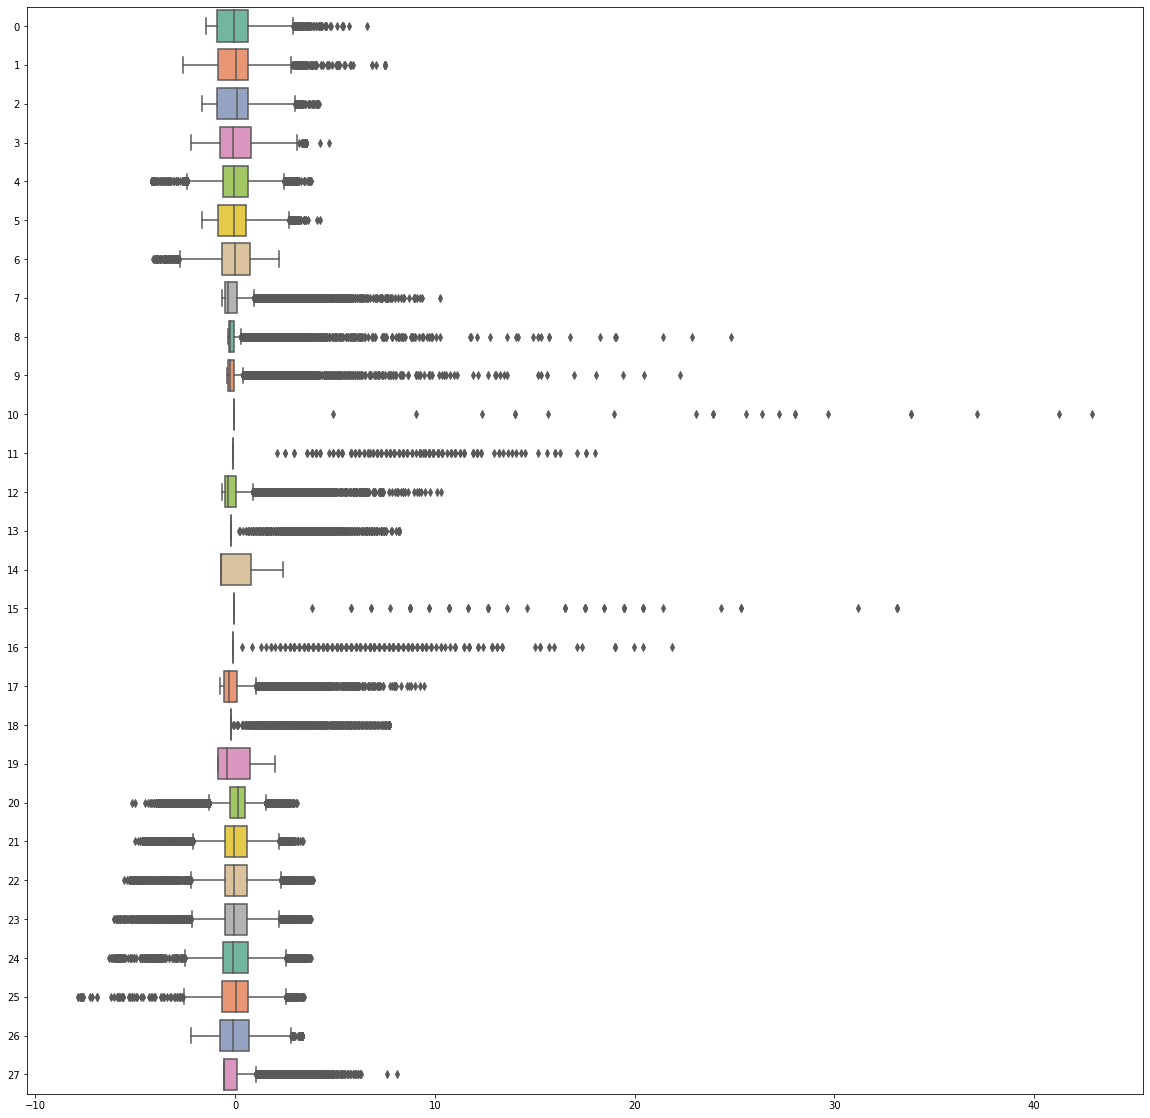

In [31]:
plt.figure(figsize = (20,20))
sns.boxplot(data = data_scaled, orient = "h", palette = "Set2")
plt.show()

In [36]:
min_max_scaler = MinMaxScaler()
data_minmax = min_max_scaler.fit_transform(data)
data_minmax = pd.DataFrame(data_minmax, columns = data.columns)
data_minmax.describe()

,ks_foreign_17,ks_inc_hh_17,ks_inc_17,ks_nondipl_17,ks_abi_17,ks_arbl_17,ks_GISD_14,geb_abs,hh_abs,pers_abs,...,imp_pct75_18,imp_pct95_18,grn_pct05,grn_pct25,grn_pct50,grn_mean,grn_pct75,grn_pct95,cvd_mortality_17,noise_mean_17
count,14702.000000,14702.000000,14702.000000,14702.000000,14702.000000,14702.000000,14702.000000,14702.000000,14702.000000,14702.000000,...,14702.000000,14702.000000,14702.000000,14702.000000,14702.000000,14702.000000,14702.000000,14702.000000,14702.000000,14702.000000
mean,0.183463,0.258458,0.284733,0.322665,0.522897,0.280892,0.650935,0.061646,0.014767,0.018368,...,0.029162,0.297369,0.622707,0.597278,0.588919,0.615609,0.626337,0.694559,0.395928,0.063591
std,0.123938,0.099105,0.171421,0.144672,0.125903,0.169294,0.157767,0.091745,0.039669,0.044120,...,0.125728,0.350562,0.121125,0.118963,0.105507,0.101718,0.098940,0.088093,0.180045,0.115454
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.072516,0.175299,0.127574,0.212128,0.449050,0.136243,0.544427,0.013900,0.001885,0.002557,...,0.000000,0.000000,0.594141,0.539053,0.533520,0.561525,0.565489,0.636693,0.260996,0.000000
50%,0.176439,0.260182,0.302578,0.309274,0.517982,0.268600,0.650257,0.030103,0.004495,0.006209,...,0.000000,0.160000,0.639334,0.589340,0.584582,0.608421,0.614934,0.696010,0.373200,0.000000
75%,0.260702,0.320459,0.397032,0.435795,0.601036,0.376673,0.766429,0.068066,0.011817,0.015905,...,0.000000,0.560000,0.680061,0.666861,0.651540,0.673981,0.689660,0.749055,0.517857,0.074174
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


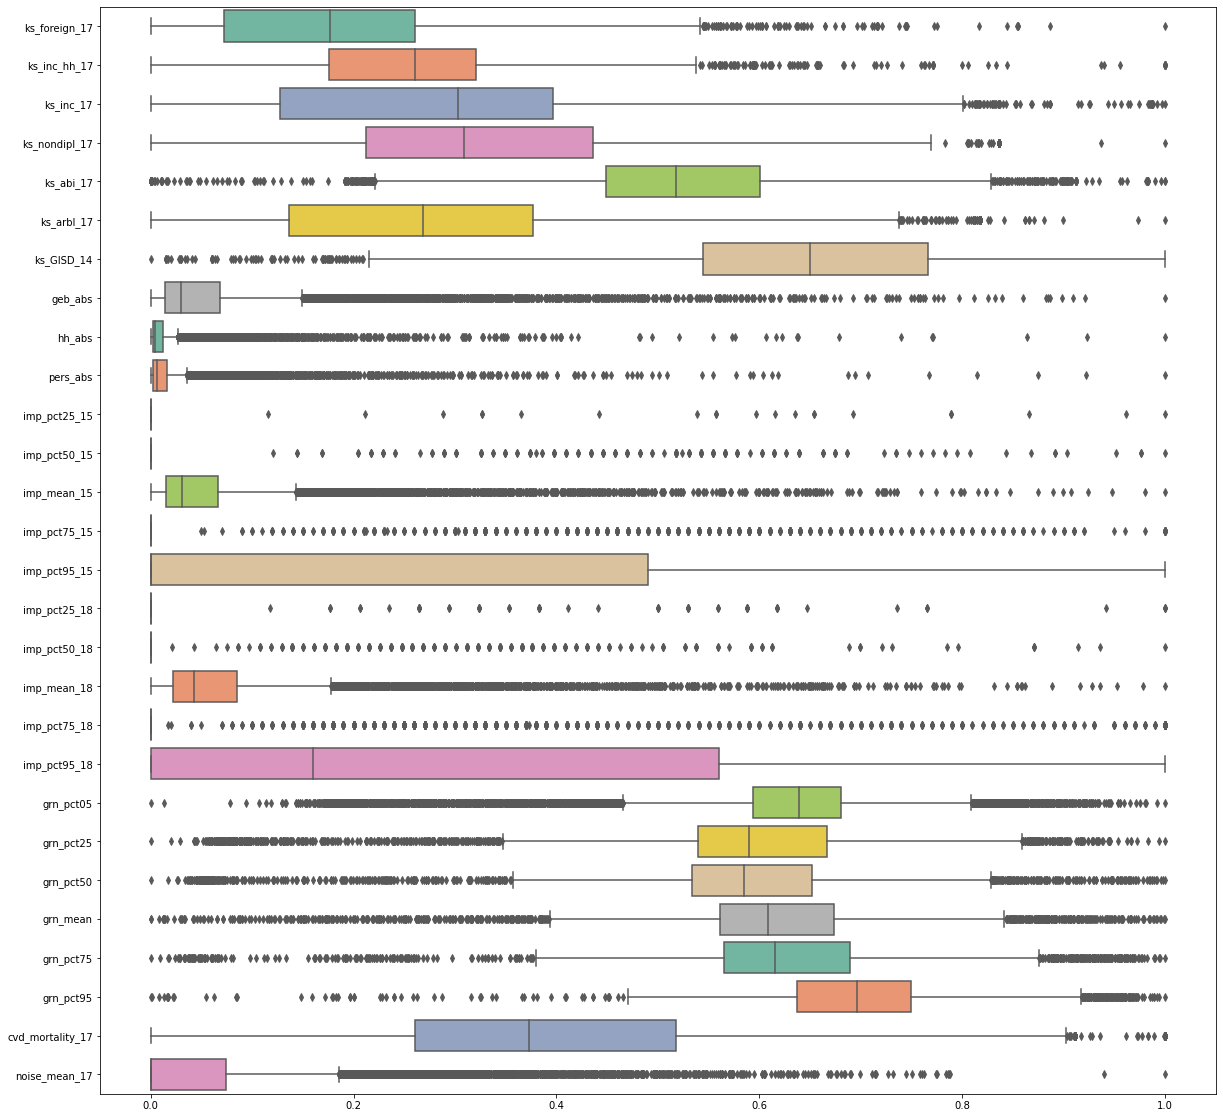

In [37]:
plt.figure(figsize = (20,20))
sns.boxplot(data = data_minmax, orient = "h", palette = "Set2")
plt.show()

## Hierarchical clustering of spearman correlation coefficients

In [6]:
data_S = data.drop(['cvd_mortality_17'], axis = 1)

Index(['x_mp', 'y_mp', 'nondipl_17', 'abi_17', 'geb_abs', 'imp_pct25_18',
       'imp_pct50_18', 'imp_pct75_18', 'grn_pct05', 'grn_pct75',
       'noise_mean_17', 'NO2_pct05_17', 'O3_pct05_17', 'PM10_pct05_17',
       'PM25_pct05_17'],
      dtype='object')


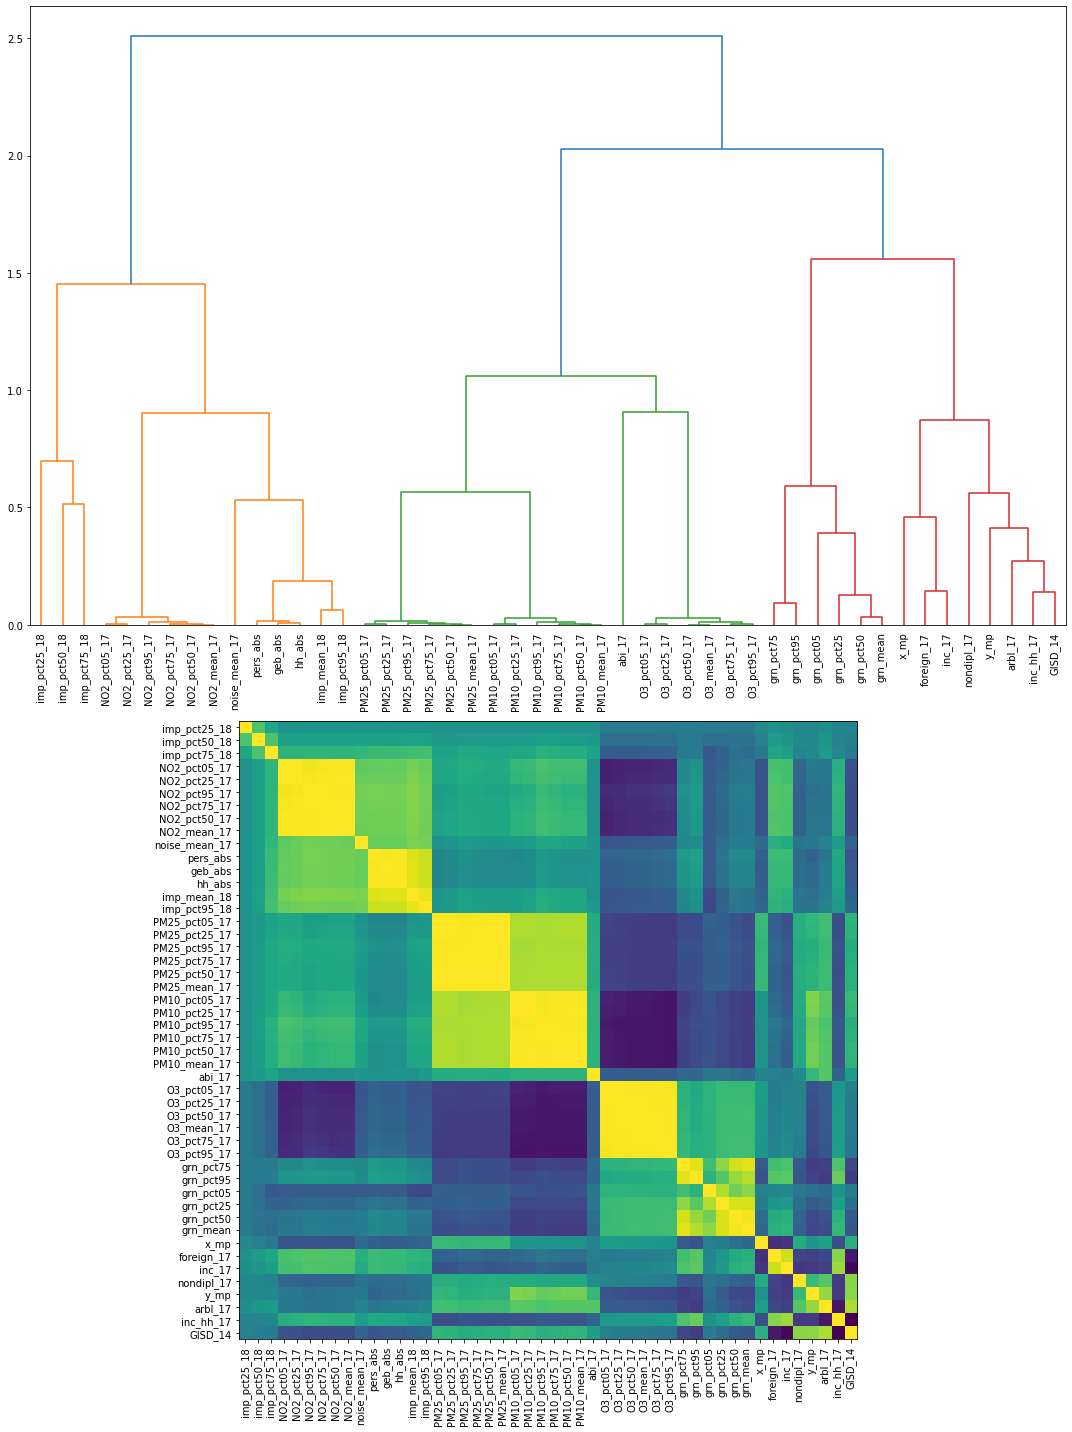

In [21]:
dist_linkage = hierachical_clustering_corr(data_S, 'Plots and descriptives/hierarchical_clustering_onCorrelations_test')
data_selected_features, selected_features = feature_selection(dist_linkage, 0.5, data_S)

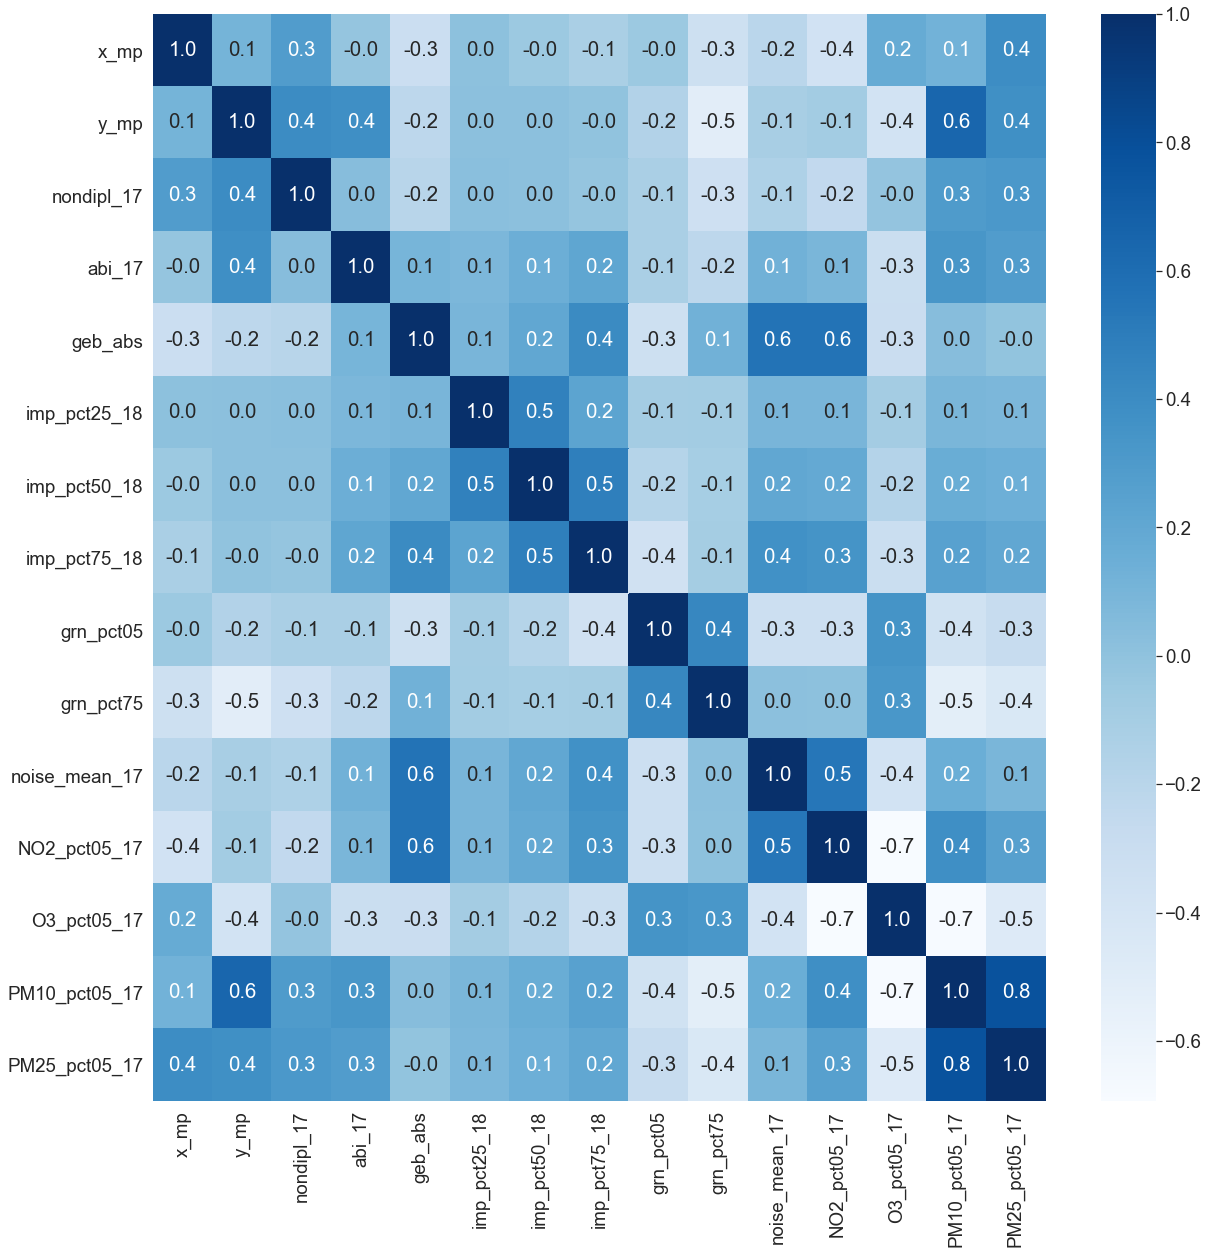

In [121]:
correlation_matrix = data_selected_features.corr(method='spearman')
plt.figure(figsize=(20,20))
sns.set(font_scale=1.7)
sns.heatmap(correlation_matrix, cbar=True, fmt='.1f', annot=True, cmap='Blues')
plt.savefig('Plots and descriptives/predictors correlation Heatmap_selescted_features')

In [10]:
data_imp_mean = data_S.drop(['imp_pct25_18', 'imp_pct50_18'], axis = 1)
data_imp_mean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14702 entries, 0 to 14701
Data columns (total 46 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   x_mp           14702 non-null  int64  
 1   y_mp           14702 non-null  int64  
 2   foreign_17     14702 non-null  float64
 3   inc_hh_17      14702 non-null  float64
 4   inc_17         14702 non-null  float64
 5   nondipl_17     14702 non-null  float64
 6   abi_17         14702 non-null  float64
 7   arbl_17        14702 non-null  float64
 8   GISD_14        14702 non-null  float64
 9   geb_abs        14702 non-null  int64  
 10  hh_abs         14702 non-null  int64  
 11  pers_abs       14702 non-null  int64  
 12  imp_mean_18    14702 non-null  float64
 13  imp_pct75_18   14702 non-null  float64
 14  imp_pct95_18   14702 non-null  float64
 15  grn_pct05      14702 non-null  float64
 16  grn_pct25      14702 non-null  float64
 17  grn_pct50      14702 non-null  float64
 18  grn_me

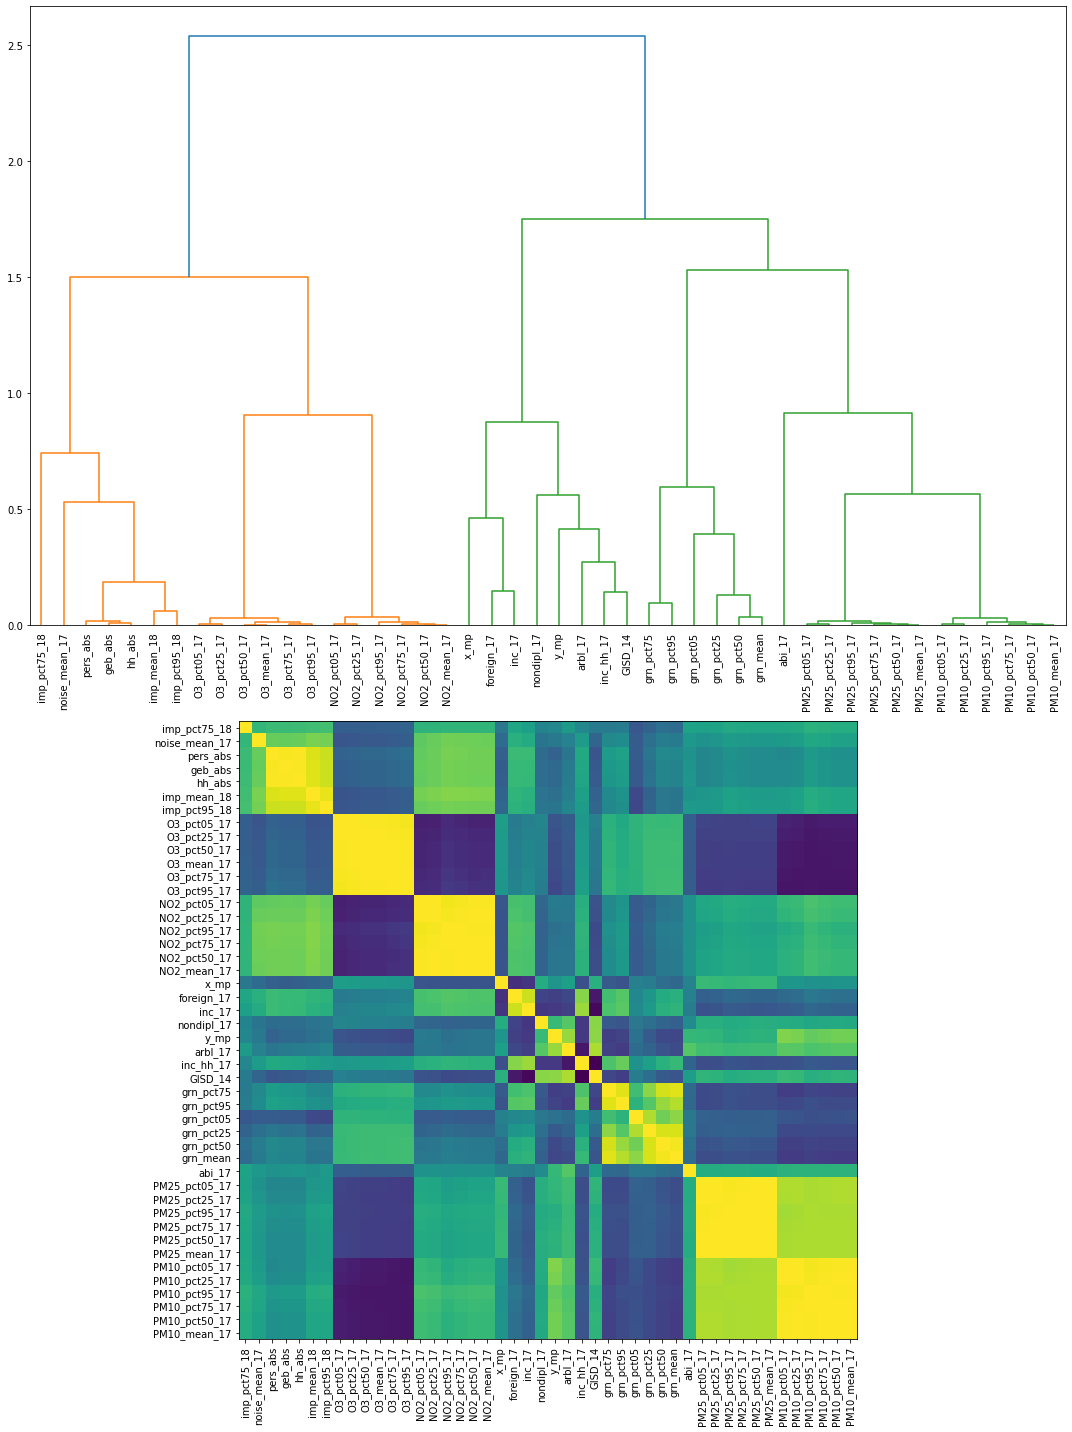

In [11]:
dist_linkage = hierachical_clustering_corr(data_imp_mean, 'Plots and descriptives/hierarchical_clustering_onCorrelations_imp_mean_test')

In [12]:
data_selected_features, selected_features = feature_selection(dist_linkage, 0.5, data_imp_mean)

Index(['x_mp', 'y_mp', 'nondipl_17', 'abi_17', 'geb_abs', 'imp_pct75_18',
       'grn_pct05', 'grn_pct75', 'noise_mean_17', 'NO2_pct05_17',
       'O3_pct05_17', 'PM10_pct05_17', 'PM25_pct05_17'],
      dtype='object')


<ipython-input-215-a9303d2efcd2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_selected_features['cvd_mortality_17'] = data.cvd_mortality_17


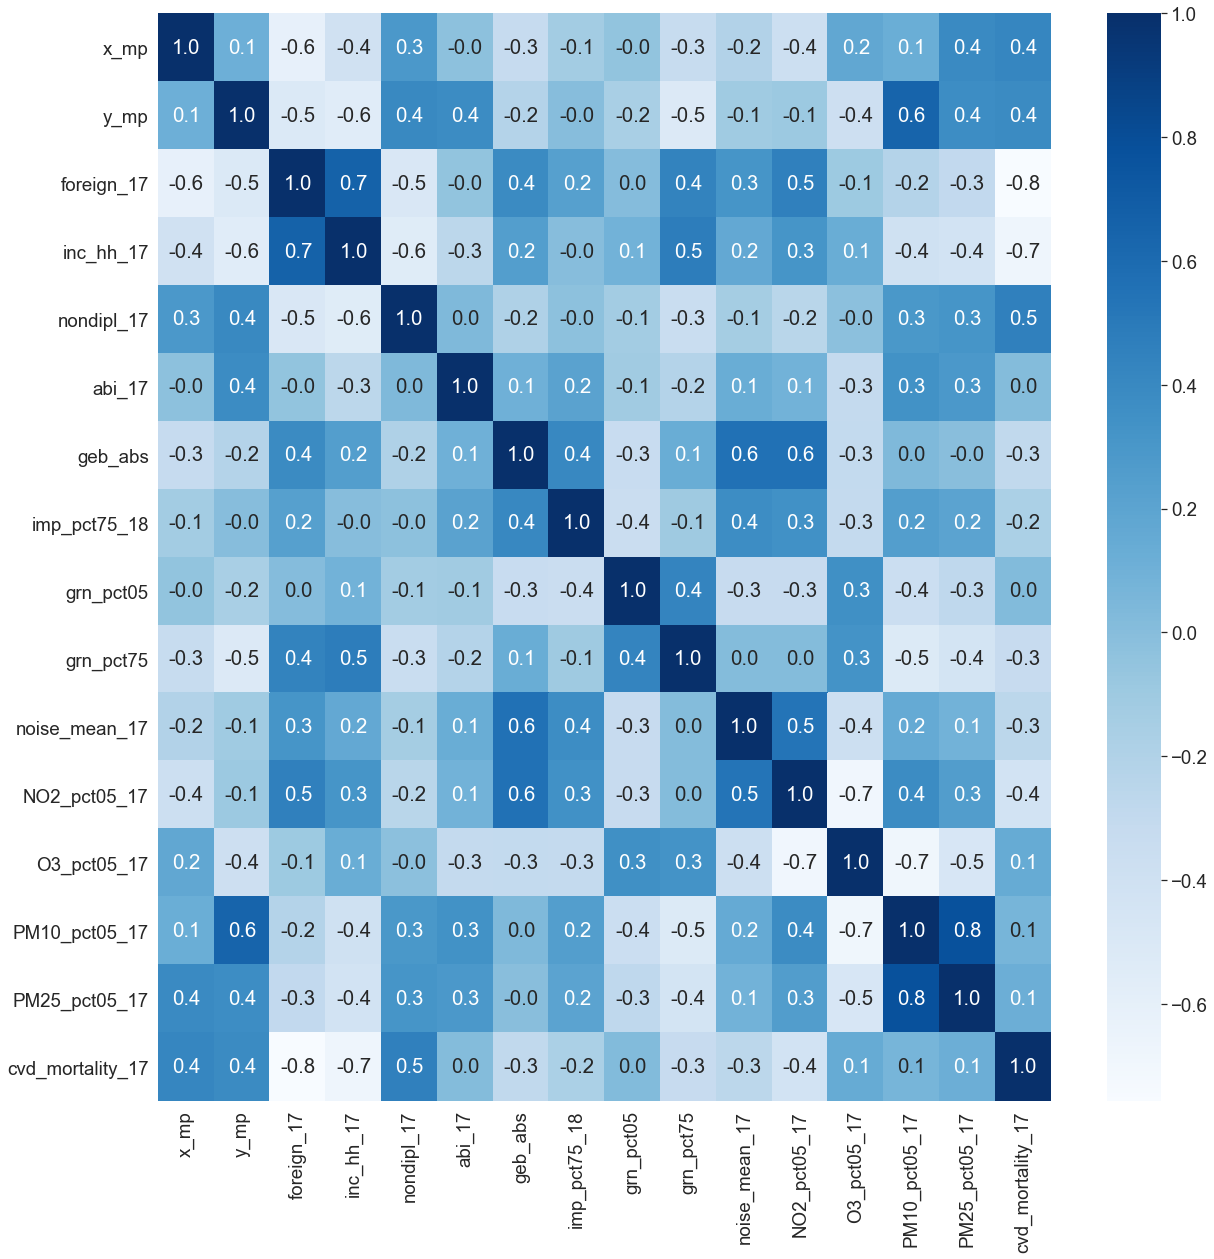

In [215]:
data_selected_features['cvd_mortality_17'] = data.cvd_mortality_17
correlation_matrix = data_selected_features.corr(method='spearman')
plt.figure(figsize=(20,20))
sns.set(font_scale=1.7)
sns.heatmap(correlation_matrix, cbar=True, fmt='.1f', annot=True, cmap='Blues')
plt.savefig('Plots and descriptives/predictors correlation Heatmap_selescted_features_imp_mean')

### Make training and test datasets

In [22]:
data_selected_features['cvd_mortality_17'] = data.cvd_mortality_17

<ipython-input-22-0f4432b84c61>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_selected_features['cvd_mortality_17'] = data.cvd_mortality_17


In [23]:
data_scaled = standard_scaler(data_selected_features, 'Prediction/Reduced_data_selected_features/Reduced_data_selected_features_scaled_05')
data_scaled['id'] = ids
make_train_test_data(NAKO_data_path, 'Prediction/Reduced_data_selected_features/Reduced_data_selected_features_scaled_05', data_scaled)
data_scaled.head()

,x_mp,y_mp,nondipl_17,abi_17,geb_abs,imp_pct25_18,imp_pct50_18,imp_pct75_18,grn_pct05,grn_pct75,noise_mean_17,NO2_pct05_17,O3_pct05_17,PM10_pct05_17,PM25_pct05_17,cvd_mortality_17,id
0,-0.092652,-1.994192,-0.821375,-1.491968,-0.587982,-0.052363,-0.108486,-0.231954,-1.835296,-1.593486,-0.55081,-1.393033,3.991873,-3.144427,-2.076604,-0.711352,5kmN2685E4330
1,-0.025219,-1.994192,-0.821375,-1.491968,-0.671495,-0.052363,-0.108486,-0.231954,-2.126597,-2.904866,-0.55081,-1.590800,4.160622,-3.421847,-2.357453,-0.711352,5kmN2685E4340
2,-0.092652,-1.970510,-0.821375,-1.491968,-0.402701,-0.052363,-0.108486,-0.231954,-1.086367,-0.157362,-0.55081,-1.393894,3.518319,-3.214965,-2.223239,-0.711352,5kmN2690E4330
3,-0.058935,-1.970510,-0.821375,-1.491968,-0.540521,-0.052363,-0.108486,-0.231954,-1.496345,-1.007186,-0.55081,-1.397590,3.439364,-3.242015,-2.206648,-0.711352,5kmN2690E4335
4,-0.025219,-1.970510,-0.821375,-1.491968,-0.649134,-0.052363,-0.108486,-0.231954,-0.911047,-0.417767,-0.55081,-1.561747,3.458173,-3.464917,-2.441192,-0.711352,5kmN2690E4340


In [24]:
data_scaled = min_max_scaler(data_selected_features, 'Prediction/Reduced_data_selected_features/Reduced_data_selected_features_minmax_scaled_05')
data_scaled['id'] = ids
make_train_test_data(NAKO_data_path, 'Prediction/Reduced_data_selected_features/Reduced_data_selected_features_minmax_scaled_05', data_scaled)
data_scaled.head()

,x_mp,y_mp,nondipl_17,abi_17,geb_abs,imp_pct25_18,imp_pct50_18,imp_pct75_18,grn_pct05,grn_pct75,noise_mean_17,NO2_pct05_17,O3_pct05_17,PM10_pct05_17,PM25_pct05_17,cvd_mortality_17,id
0,0.468750,0.00000,0.203839,0.33506,0.007704,0.0,0.0,0.0,0.400414,0.468683,0.0,0.083714,0.918136,0.161373,0.089757,0.267857,5kmN2685E4330
1,0.484375,0.00000,0.203839,0.33506,0.000042,0.0,0.0,0.0,0.365131,0.338939,0.0,0.063186,0.935446,0.130122,0.047837,0.267857,5kmN2685E4340
2,0.468750,0.00578,0.203839,0.33506,0.024702,0.0,0.0,0.0,0.491125,0.610768,0.0,0.083625,0.869563,0.153427,0.067870,0.267857,5kmN2690E4330
3,0.476562,0.00578,0.203839,0.33506,0.012058,0.0,0.0,0.0,0.441468,0.526689,0.0,0.083241,0.861464,0.150380,0.070346,0.267857,5kmN2690E4335
4,0.484375,0.00578,0.203839,0.33506,0.002093,0.0,0.0,0.0,0.512360,0.585005,0.0,0.066201,0.863393,0.125271,0.035337,0.267857,5kmN2690E4340


In [25]:
data_selected_features['id'] = ids
data_selected_features.to_csv('Prediction/Reduced_data_selected_features/Reduced_data_selected_features_05.csv', sep = ',', index = False)
make_train_test_data(NAKO_data_path, 'Prediction/Reduced_data_selected_features/Reduced_data_selected_features_05', data_selected_features)
data_selected_features.head()

<ipython-input-25-9dbf9577e37c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_selected_features['id'] = ids


,x_mp,y_mp,nondipl_17,abi_17,geb_abs,imp_pct25_18,imp_pct50_18,imp_pct75_18,grn_pct05,grn_pct75,noise_mean_17,NO2_pct05_17,O3_pct05_17,PM10_pct05_17,PM25_pct05_17,cvd_mortality_17,id
0,4332500,2687500,5.0,19.4,184,0,0,0.0,-0.009367,0.117133,40.0,4.966619,73.571130,7.244495,7.280847,4.0,5kmN2685E4330
1,4342500,2687500,5.0,19.4,1,0,0,0.0,-0.020167,0.061067,40.0,4.347993,74.385780,6.755102,6.921812,4.0,5kmN2685E4340
2,4332500,2692500,5.0,19.4,590,0,0,0.0,0.018400,0.178533,40.0,4.963928,71.285015,7.120059,7.093390,4.0,5kmN2690E4330
3,4337500,2692500,5.0,19.4,288,0,0,0.0,0.003200,0.142200,40.0,4.952366,70.903857,7.072342,7.114600,4.0,5kmN2690E4335
4,4342500,2692500,5.0,19.4,50,0,0,0.0,0.024900,0.167400,40.0,4.438870,70.994656,6.679124,6.814760,4.0,5kmN2690E4340
